## This script compares batch-correction of normalised counts by either Harmony or MNN.

In [1]:
import os
import sklearn
import pickle
import pandas as pd
import numpy as np
import graphtools as gt
import phate
import magic
import scprep
import meld
print(meld.version)
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import harmonypy as hm

np.random.seed(42)
font = {'size'   : 14}
mpl.rc('font', **font)

if os.path.isdir('/Users/mac/cloudstor/') == True:
    place = 'local'
    indir = '/Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/practice_all_data/'
    outdir = '/Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/meld/practice_all_data/'
    dataset = 'practice'
else:
    place = 'wolfpack'
    indir = '/share/ScratchGeneral/scoyou/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/all_data/'
    outdir = '/share/ScratchGeneral/scoyou/sarah_projects/SCMDA231mets_chrcha/project_results/meld/all_data/'
    dataset = 'all'

print('Place: ', place,
       'indir: ', indir,
       'outdir: ', outdir)

<module 'meld.version' from '/Users/mac/cloudstor/scripts/MELD/meld/version.py'>
Place:  local indir:  /Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/practice_all_data/ outdir:  /Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/meld/practice_all_data/


Load counts filtered for lowly expressed genes and low quality cells (2MAD each sample library size, gene counts, 2MAD whole experiment mito content).

In [2]:
filtered_counts = scprep.io.load_csv(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_filtered_counts.csv'))
print(filtered_counts.head())

                      AL669831.5  LINC00115  FAM41C  NOC2L  KLHL17  PLEKHN1  \
1_AAACCTGCATTGTGCA-1           0          0       0      0       0        0   
1_AAACCTGGTGTGACGA-1           0          0       0      3       0        0   
1_AAACGGGGTCGTCTTC-1           1          1       0      0       0        0   
1_AAAGTAGCATGGGACA-1           0          0       0      1       0        0   
1_AAAGTAGTCGTCTGAA-1           0          0       0      4       0        1   

                      AL645608.8  HES4  ISG15  AGRN  ...  MT.ATP8  MT.ATP6  \
1_AAACCTGCATTGTGCA-1           0     0      0     0  ...        1       50   
1_AAACCTGGTGTGACGA-1           0     0      4     0  ...        0       93   
1_AAACGGGGTCGTCTTC-1           0     0      2     2  ...        0      181   
1_AAAGTAGCATGGGACA-1           0     0      3     0  ...        0      131   
1_AAAGTAGTCGTCTGAA-1           0     0      0     2  ...        0      152   

                      MT.CO3  MT.ND3  MT.ND4L  MT.ND4  M

Make object containing metadata for each cell

In [3]:
colData = scprep.io.load_csv(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_colData.csv'))
metadata = colData[['Sample', 'Tissue', 'Replicate']].astype(str)
str_reps = metadata['Replicate'].astype(str)
metadata.loc[:, ('Replicate')] = str_reps
print(metadata.head())

                       Sample Tissue Replicate
1_AAACCTGCATTGTGCA-1  Liver_1  Liver         1
1_AAACCTGGTGTGACGA-1  Liver_1  Liver         1
1_AAACGGGGTCGTCTTC-1  Liver_1  Liver         1
1_AAAGTAGCATGGGACA-1  Liver_1  Liver         1
1_AAAGTAGTCGTCTGAA-1  Liver_1  Liver         1


#### Normalise counts and standardise library size

Standardise library size

In [4]:
data_norm = scprep.scprep.normalize.library_size_normalize(filtered_counts, rescale=1000)

Square root transform.

In [5]:
data_sqrt = scprep.transform.sqrt(data_norm)

Detect highly variable genes. These will be used for batch correction and graph construction.

In [6]:
data_sqrt_centered = scprep.normalize.batch_mean_center(np.array(data_sqrt), sample_idx=metadata['Replicate'])
data_sqrt_hvg = scprep.select.highly_variable_genes(data_sqrt_centered, percentile=33)
print(data_sqrt_hvg)

[[-0.01146108 -0.0099385  -0.01168923 ... -0.08436995 -0.17521305
   0.25912708]
 [-0.01146108 -0.0099385  -0.01168923 ... -0.31949192 -0.17521305
  -0.60779135]
 [ 0.17163874  0.17316133 -0.01168923 ... -0.14780082  0.23421061
  -0.27840798]
 ...
 [-0.01111578 -0.00512358 -0.00902228 ... -0.2513146  -0.13299466
  -0.10200869]
 [-0.01111578 -0.00512358 -0.00902228 ... -0.53081546 -0.13299466
   0.71077283]
 [-0.01111578 -0.00512358 -0.00902228 ...  0.24352013 -0.13299466
  -0.37885846]]


#### Embed cells and visualise without batch correction

In [7]:
G = gt.Graph(data_sqrt_hvg, knn=10, decay=40, n_pca=100, n_jobs=-2, verbose=True, random_state=42)

Calculating PCA...
Calculated PCA in 4.23 seconds.
Calculating KNN search...
Calculated KNN search in 1.47 seconds.
Calculating affinities...
Calculated affinities in 0.22 seconds.


In [8]:
phate_op = phate.PHATE(knn_dist='precomputed', t='auto', gamma=1, n_jobs=-2, n_components=2, random_state=42)
data_phate = phate_op.fit_transform(G.kernel)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 7055 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.62 seconds.
    Calculating KMeans...
    Calculated KMeans in 30.78 seconds.
  Calculated landmark operator in 32.78 seconds.
  Calculating optimal t...
  Calculated optimal t in 2.71 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 10.48 seconds.
Calculated PHATE in 47.02 seconds.


In [9]:
rep_cmap = {1: '#42a5f0',
            2: '#a5f042',
            3: '#e442f0',
            4: '#f0424e'}

tissue_cmap = {'Primary': '#E69F00',
               'LN': '#56B4E9',
               'Liver': '#009E73',
               'Lung': '#F0E442'}

sample_cmap = {'Primary_1': '#E69F00',
               'Primary_2': '#ffb000',
               'Primary_3': '#ffb81a',
               'Primary_4': '#ffc034',
               'LN_1': '#56B4E9',
               'LN_2': '#6dbeec',
               'LN_3': '#83c8ef',
               'LN_4': '#9ad2f2',
               'Liver_1': '#009E73',
               'Liver_2': '#00b886',
               'Liver_3': '#00d198',
               'Liver_4': '#00ebab',
               'Lung_1': '#F0E442',
               'Lung_2': '#f2e75a',
               'Lung_3': '#f4eb71',
               'Lung_4': '#f6ee89'}

cmaps = {'rep_cmap': rep_cmap, 'tissue_cmap': tissue_cmap, 'sample_cmap': sample_cmap}

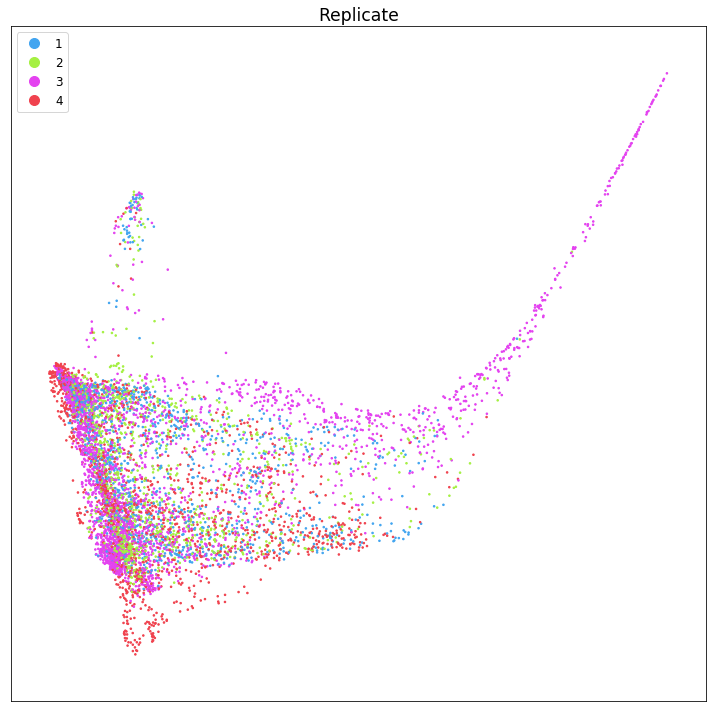

In [10]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)
scprep.plot.scatter2d(data_phate, c=list(colData['Replicate']), cmap=cmaps['rep_cmap'], ticks=False, ax=ax, title='Replicate')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'Replicate_NO_batch_correction_PHATE.png'), dpi=300)

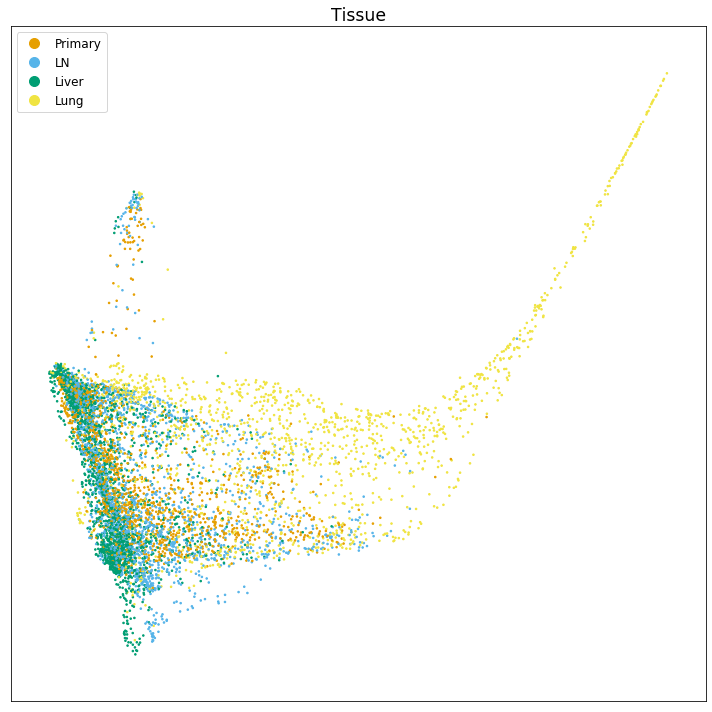

In [11]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)
scprep.plot.scatter2d(data_phate, c=list(colData['Tissue']), cmap=cmaps['tissue_cmap'], ticks=False, ax=ax, title='Tissue')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'Tissue_NO_batch_correction_PHATE.png'), dpi=300)

#### Batch correct normalised counts using MNN

Construct graph based on highly variable genes

In [37]:
G = gt.Graph(np.array(data_sqrt_hvg), sample_idx=metadata['Replicate'], decay=40, knn=10, theta=0.95, n_pca=100, kernel_symm='mnn', n_jobs=-2, verbose=True, random_state=42)

Calculating PCA...
Calculated PCA in 4.25 seconds.
Calculating subgraphs...
  Calculating KNN search...
  Calculated KNN search in 0.20 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.21 seconds.
  Calculating affinities...
  Calculated affinities in 0.01 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.85 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.28 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated subgraphs in 1.67 seconds.
Calculating MNN kernel...
  Calculating kernel from sample 1 to 2...
    Calculating KNN search...
    Calculated KNN search in 0.20 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated kernel from sample 1 to 2 in 0.41 seconds.
  Calculating kernel from sample 1 to 3...
    Calculating KNN 

In [38]:
phate_op = phate.PHATE(knn_dist='precomputed', t='auto', gamma=1, n_jobs=-2, n_components=2, random_state=42)
data_phate = phate_op.fit_transform(G.kernel)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 7055 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.11 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.60 seconds.
    Calculating KMeans...
    Calculated KMeans in 27.15 seconds.
  Calculated landmark operator in 30.30 seconds.
  Calculating optimal t...
  Calculated optimal t in 3.17 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.11 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 10.66 seconds.
Calculated PHATE in 45.36 seconds.


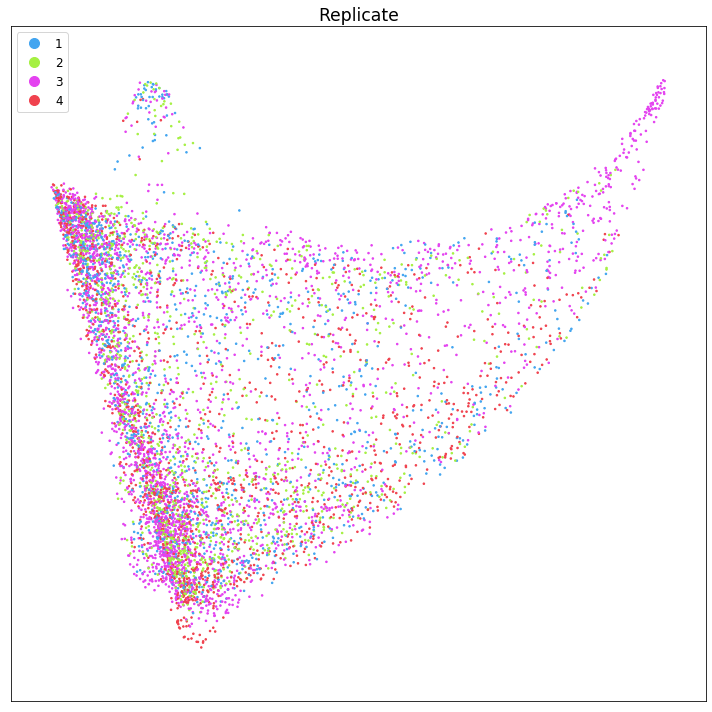

In [39]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)
scprep.plot.scatter2d(data_phate, c=list(colData['Replicate']), cmap=cmaps['rep_cmap'], ticks=False, ax=ax, title='Replicate')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'Replicate_MNN_batch_correction_PHATE.png'), dpi=300)

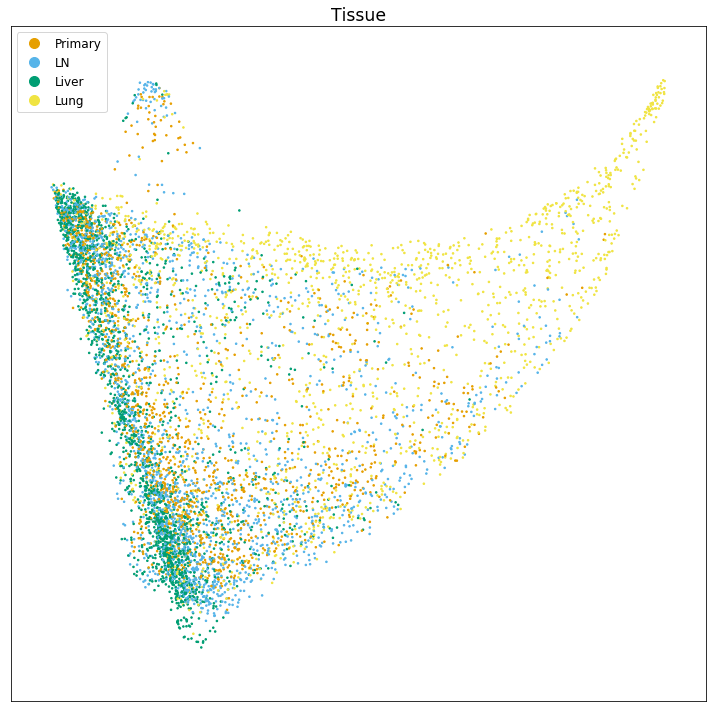

In [40]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)
scprep.plot.scatter2d(data_phate, c=list(colData['Tissue']), cmap=cmaps['tissue_cmap'], ticks=False, ax=ax, title='Tissue')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'Tissue_MNN_batch_correction_PHATE.png'), dpi=300)

#### Batch correct normalised counts using Harmony

In [17]:
data_sqrt_hvg_pcs = scprep.reduce.pca(data_sqrt_hvg, n_components=100, return_singular_values=False)
ho = hm.run_harmony(np.array(data_sqrt_hvg_pcs), metadata, 'Replicate', plot_convergence=False, max_iter_kmeans=100, random_state=42)
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
data_harmony_corrected = pd.DataFrame(res.T)

2020-07-27 13:45:09,809 - harmonypy - INFO - Iteration 1 of 100
2020-07-27 13:45:17,999 - harmonypy - INFO - Iteration 2 of 100
2020-07-27 13:45:20,671 - harmonypy - INFO - Iteration 3 of 100
2020-07-27 13:45:22,427 - harmonypy - INFO - Iteration 4 of 100
2020-07-27 13:45:23,568 - harmonypy - INFO - Iteration 5 of 100
2020-07-27 13:45:24,521 - harmonypy - INFO - Iteration 6 of 100
2020-07-27 13:45:25,366 - harmonypy - INFO - Iteration 7 of 100
2020-07-27 13:45:26,055 - harmonypy - INFO - Iteration 8 of 100
2020-07-27 13:45:26,811 - harmonypy - INFO - Iteration 9 of 100
2020-07-27 13:45:27,494 - harmonypy - INFO - Iteration 10 of 100
2020-07-27 13:45:28,172 - harmonypy - INFO - Iteration 11 of 100
2020-07-27 13:45:28,819 - harmonypy - INFO - Iteration 12 of 100
2020-07-27 13:45:29,512 - harmonypy - INFO - Converged after 12 iterations


In [18]:
G = gt.Graph(np.array(data_harmony_corrected), decay=40, knn=10, n_pca=None, n_jobs=-2, verbose=True, random_state=42)

Calculating KNN search...
Calculated KNN search in 1.36 seconds.
Calculating affinities...
Calculated affinities in 0.22 seconds.


In [19]:
phate_op = phate.PHATE(knn_dist='precomputed', t='auto', gamma=1, n_jobs=-2, n_components=2, random_state=42)
data_phate = phate_op.fit_transform(G.kernel)

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 7055 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.03 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.73 seconds.
    Calculating KMeans...
    Calculated KMeans in 26.93 seconds.
  Calculated landmark operator in 28.96 seconds.
  Calculating optimal t...
  Calculated optimal t in 2.63 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.74 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 10.85 seconds.
Calculated PHATE in 43.21 seconds.


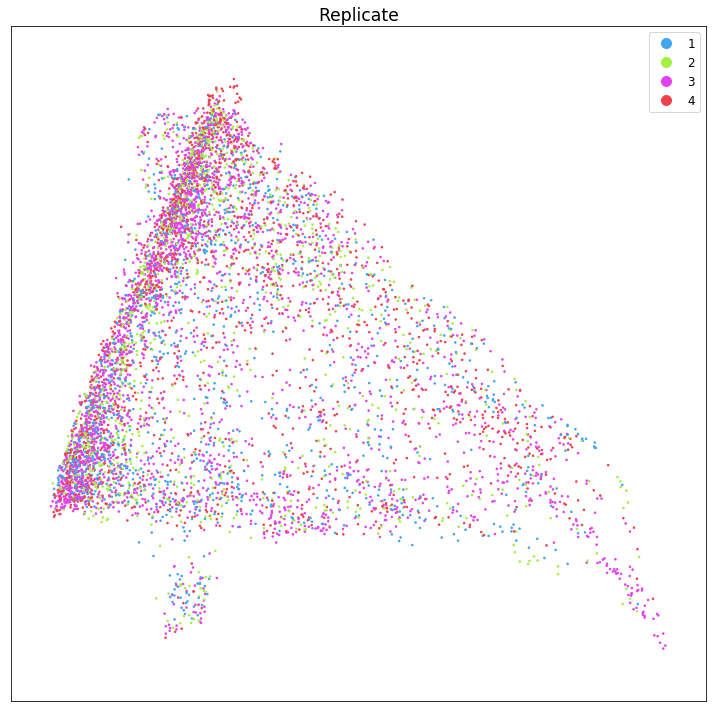

In [20]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)
scprep.plot.scatter2d(data_phate, c=list(colData['Replicate']), cmap=cmaps['rep_cmap'], ticks=False, ax=ax, title='Replicate')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'Replicate_HARMONY_batch_correction_PHATE.png'), dpi=300)

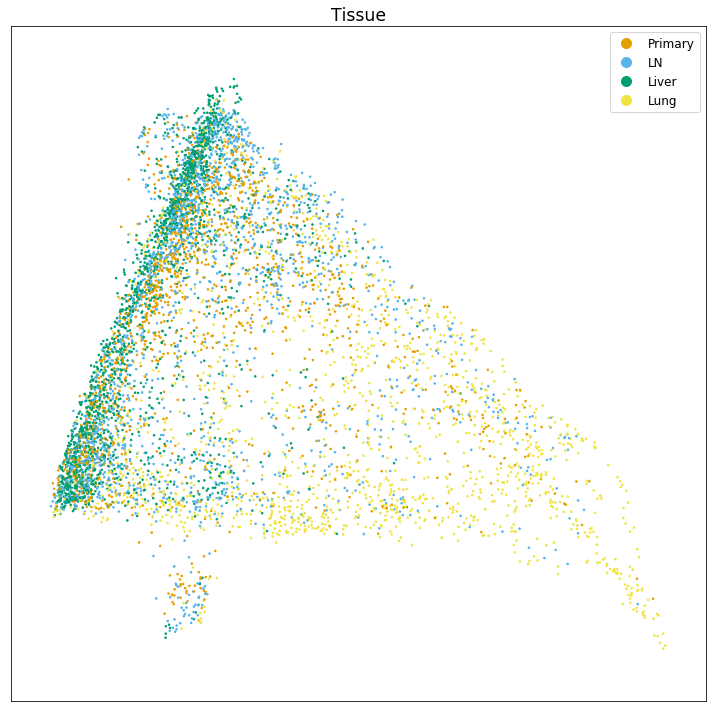

In [21]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)
scprep.plot.scatter2d(data_phate, c=list(colData['Tissue']), cmap=cmaps['tissue_cmap'], ticks=False, ax=ax, title='Tissue')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'Tissue_HARMONY_batch_correction_PHATE.png'), dpi=300)